In [4]:
!pip install transformers

In [5]:
import sys

sys.path.append('/home/devlab/hmp_utils')
if '../' not in sys.path:
    sys.path.append('../')

In [6]:
import json
import glob
import os
import random

import sys

sys.path.append('/home/michieletto/hmp_utils') # Passaggio cartelle per trovare hmp_utils
if '../' not in sys.path:
    sys.path.append('../')

from hmp_utils.motion.body_models_constants import SmplConstants
from hmp_utils.motion.mocap_processor import MocapLoader
from hmp_utils.motion.kinematics import ForwardKinematics
from hmp_utils.visualize.stickman_animation import pose_animation, CameraOrientation, AnimationMode

from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
import numpy as np
import pandas as pd


In [7]:
dataset = []

# Definisci il percorso completo del file JSON
percorso_file_train = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/train.json'
percorso_file_val   = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/val.json'
percorso_file_test  = '/home/michieletto/datasets/BABEL_DATASET/babel_v1.0_release/test.json'

dataset.append(percorso_file_train)
dataset.append(percorso_file_val)
dataset.append(percorso_file_test)

data = {}           # Dizionario contenente l'intero dataset  

# Apre il file JSON in modalità lettura
for i,percorso_file in enumerate(dataset):
    with open(percorso_file, 'r') as f:
        # Carica i dati JSON
        data.update(json.load(f))


In [8]:
occur_lab = {
    'label': [],               
    'feat_p': []
    } 

for i, k in enumerate(data.keys()):
    label = data[k]["seq_ann"]["labels"][0]["raw_label"]
    feat_p = data[k]["feat_p"]

    occur_lab["label"].append(label)
    occur_lab["feat_p"].append(feat_p)



In [9]:

directory = '/home/michieletto/datasets/AMASS_H/ACCAD'
file_paths = glob.glob(directory + '/**/*.npz', recursive=True) # ottiene tutti i file nelle diverse cartelle contenenti i mocap in una stringa

directory = '/home/michieletto/datasets/AMASS_H/KIT/KIT'
file_paths += glob.glob(directory + '/**/*.npz', recursive=True)

file_paths = sorted(file_paths)
print(len(file_paths))

rand_x = random.randint(0, len(file_paths))
filepath = file_paths[rand_x]

file_name = os.path.basename(filepath)    # ottiene il nome del file
folder_path = os.path.dirname(filepath)   # ottiene il percorso fino alla cartella in cui è contenuto il file
last_folder_name = os.path.basename(folder_path)     # ottiene il nome dell'ultima cartella
last_folder_and_file_name = os.path.join(last_folder_name, file_name)     # unisce i due nomi

for i in range(len(occur_lab["feat_p"])):
    if last_folder_and_file_name in occur_lab["feat_p"][i]:
        print(occur_lab["label"][i], occur_lab["feat_p"][i])


4484
walk KIT/KIT/9/LeftTurn07_poses.npz


In [10]:

frame_to_plot = 0

# -- load mocap --
mocap_loader=MocapLoader(body_model_type=SmplConstants.BODY_MODEL_TYPE,
                         keypoint_ids_to_load=SmplConstants.KEYPOINTS,
                         target_framerate = 25)

motions = []
motions = [mocap_loader.load_mocap(path) for path in file_paths]     # lista delle classi di tutti i mocap

# -- compute joint positions --
kine = ForwardKinematics(SmplConstants.OFFSETS, SmplConstants.PARENTS)
kine.set_body_model_type(SmplConstants.BODY_MODEL_TYPE)

all_keypoints_positions = []
for i, motion in enumerate(motions):
    if motion is not None:
        all_keypoints_positions.append(kine.compute_fk(motion.rots, apply_root_rotation=True))

keypoints_positions = all_keypoints_positions[rand_x][frame_to_plot]

print(len(all_keypoints_positions))

# -- plot --
# plot_body_keypoints(keypoints_positions, SmplConstants.PARENTS, azimuth=0, keypoint_size = 5, link_size=1, 
#                     show_keypoint_id=True, body_rotation=(0,0,45))

4483


In [11]:
keypoints_positions = all_keypoints_positions[rand_x][:250]
print(keypoints_positions.shape)

motions_list = [keypoints_positions]
subplot_ids = [0]
subplot_titles = ['Amass']
camera_orientations = [CameraOrientation(100, 20)]
# pose_animation(motions_list, SmplConstants.PARENTS, animation_framerate = 60, subplot_ids=subplot_ids, 
#                camera_orientations=camera_orientations, subplot_titles=subplot_titles,
#                fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML)

(119, 24, 3)


In [12]:
frame_vocab = []
cont = 0
for i in range(len(motions)):
    if motions[i] is not None:
        if len(motions[i].rots) >= 75:
            rand_x = random.randint(0, len(motions[i].rots) - 75)
            frame_vocab.append(motions[i].rots[rand_x:rand_x + 75])
            assert len(frame_vocab[-1]) == 75

            frame_vocab[-1] = [[angle for k_point in frame for angle in k_point] for frame in frame_vocab[-1]]
            assert len(frame_vocab[-1][0]) == 72
        else:
            cont += 1
    else:
        cont += 1

sum = 0
for i in range(len(frame_vocab)):
    sum += len(frame_vocab[i])

frame_vocab = pd.DataFrame(frame_vocab)
frame_vocab_copy = frame_vocab.copy()

print(f"Numero di mocap non validi: {cont}")
print(f"Il numero totale di frame è: {sum}")


Numero di mocap non validi: 131
Il numero totale di frame è: 326475


In [13]:

# def similarity_metric(arr1, arr2):
#     # Calcola la correlazione tra gli array
#     corr = np.corrcoef(arr1.flatten(), arr2.flatten())[0, 1]
#     return corr

# def build_similarity_matrix(arrays):
#     n = len(arrays)
#     similarity_matrix = np.zeros((n, n))

#     for i in range(n):
#         for j in range(i + 1, n):
#             similarity_matrix[i, j] = similarity_metric(arrays[i], arrays[j])
#             similarity_matrix[j, i] = similarity_matrix[i, j]  # Poiché la matrice è simmetrica
#     return similarity_matrix

# def save_unique_arrays(arrays, threshold):
#     similarity_matrix = build_similarity_matrix(arrays) # matrice contenente la percentuale di similitudine di tutte le combinazioni tra array
#     unique_arrays = [arrays[0]]  # Inizia con il primo array
#     similar_counts = []

#     n = len(similarity_matrix)
#     i = 0
#     saved_idx = []
#     rows_ids = []

#     while(i < n):       # ciclo sul triangolo superiore della matrice di somiglianza per trovare quali array si assomigliano
#         for j in range(i+1, n):     # trovo gli indici degli array simili
#             if not rows_ids:
#                 if (similarity_matrix[i, j] > threshold):
#                     saved_idx.append(j)
#             else:
#                 if all(j not in sublist for sublist in rows_ids):
#                     if (similarity_matrix[i, j] > threshold):
#                         saved_idx.append(j)

#         if saved_idx:
#             rows_ids.append(saved_idx)
#             similar_counts.append(len(rows_ids[-1]) + 1)
#             saved_idx = []

#         for j in range(i+1, n):     # trovo gli array "unici"
#             if all(j not in sublist for sublist in rows_ids):
#                 if (similarity_matrix[i, j] < threshold):
#                     unique_arrays.append(arrays[i])
#                     i = j - 1
#                     break
#                 break
        
#         i += 1
                
#     return unique_arrays, similar_counts

In [14]:
# frame_vocab = {
#     'frame': [],
#     'recurrence': [],
#     'frame_id': []
# }

# # Imposta una soglia di similarità
# threshold = 0.99

# for i in range(len(all_keypoints_positions)):
#     i=1
#     # Salva gli array unici
#     unique_arrays, similar_counts = save_unique_arrays(all_keypoints_positions[i], threshold)
#     break

# frame_vocab["frame"] = unique_arrays
# frame_vocab['recurrence'] = similar_counts

# sum=0
# for i in range(len(frame_vocab['recurrence'])):
#     sum+=frame_vocab['recurrence'][i]

# print(f"Numero di frame salvati: {len(frame_vocab['frame'])}")
# print(f"Numero di frame totali: {len(all_keypoints_positions[1])}")
# print(f"Somma delle ricorrenze: {sum}")
# print("Dimensione e Array ricorrenze:", len(frame_vocab['recurrence']), frame_vocab['recurrence'])


In [15]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 72
75 72


In [16]:
# Funzione per eliminare una colonna da ogni matrice
def elimina_colonna(matrice, indexes_to_exclude):

    return [np.delete(row, indexes_to_exclude) for row in matrice]

indexes_to_exclude = [0,1,2, 30,31,32, 33,34,35, 66,67,68, 69,70,71] # Indici corrispondenti ai keypoint 0,10,11,22,23
# Applica la funzione a ogni elemento del DataFrame
frame_vocab = frame_vocab.apply(elimina_colonna, indexes_to_exclude = indexes_to_exclude)

In [17]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 57
75 72


In [18]:
train_data, test_data = train_test_split(frame_vocab, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print(len(train_data), len(valid_data), len(test_data))


3482 435 436


In [19]:
def get_collate_fn():
    def collate_fn(batch):
        batch = [[row[i] for row in batch] for i in range(len(batch[0]))]
        batch = torch.tensor(batch)
        batch = batch.float()
        
        return batch

    return collate_fn

In [20]:
def get_data_loader(dataset, batch_size, shuffle=False):
    collate_fn = get_collate_fn()
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [21]:
batch_size = 64

train_data_loader = get_data_loader(train_data.values.tolist(), batch_size, shuffle=True)
valid_data_loader = get_data_loader(valid_data.values.tolist(), batch_size)
test_data_loader = get_data_loader(test_data.values.tolist(), batch_size)


batch = next(iter(train_data_loader))
print(type(batch), len(batch))
print(type(batch[0]), len(batch[0]))
print(type(batch[0][0]), len(batch[0][0]))


<class 'torch.Tensor'> 75
<class 'torch.Tensor'> 64
<class 'torch.Tensor'> 57


/tmp/ipykernel_1168615/4005506767.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch = torch.tensor(batch)


In [22]:
class Encoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)

    def forward(self, src):
        
        # src = [src length, batch size, dense_vector_dim]
        outputs, (hidden, cell) = self.rnn(src)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

In [23]:
class Decoder(nn.Module):
    def __init__(self, dense_vector_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = dense_vector_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(dense_vector_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, dense_vector_dim)

    def forward(self, input, hidden, cell):
        # input = [batch size, dense_vector_dim]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size, dense_vector_dim]
        output, (hidden, cell) = self.rnn(input, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        input = input.squeeze(0)
        prediction = input + prediction
        
        return prediction, hidden, cell

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]

        input = src[-1, :]
        # input = [batch size, output_dim]
        for t in range(trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # outputs = [trg_lenght, batch_size, dense_vector_dim]
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            # top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else output
            # input = [batch size]
        
        return outputs

In [25]:

dense_vector_encoder_dim = 57 
dense_vector_decoder_dim = 57 
hidden_dim = 512
n_layers = 1
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    dense_vector_encoder_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    dense_vector_decoder_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

/home/michieletto/venv_pmerc/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
# def init_weights(m):
#     for name, param in m.named_parameters():
#         nn.init.uniform_(param.data, -0.08, 0.08)

# model.apply(init_weights)

In [27]:
# Number of iterations
EPOCHS = 50

# Optimizer Adam
optimizer = optim.Adam(model.parameters(), lr=2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [28]:
def train_fn(
    model, data_loader, optimizer, scheduler, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    num_mocap = 0
    for i, batch in enumerate(data_loader):
        src_lenght = 50
        trg_lenght = 25

        src = batch[:src_lenght].to(device)
        trg = batch[-trg_lenght:].to(device)
        # src = [src length, batch size, dense_vector_dim]
        # trg = [trg length, batch size, dense_vector_dim]
        
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, dense_vector_dim]
        output_dim = output.shape[-1]
        output = output[:].view(-1, output_dim)
        # output = [trg length * batch size, dense_vector_dim]
        trg = trg[:].view(-1, output_dim)
        # trg = [trg length * batch size, dense_vector_dim]
        loss = torch.square(output - trg)
        loss = torch.sum(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [29]:
def evaluate_fn(model, data_loader, device):
    model.eval()
    epoch_loss = 0
    num_mocap = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src_lenght = 50
            trg_lenght = 25

            src = batch[:src_lenght].to(device)
            trg = batch[-trg_lenght:].to(device)
            # src = [src length, batch size, dense_vector_dim]
            # trg = [trg length, batch size, dense_vector_dim]

            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[:].view(-1, output_dim)
            # output = [trg length * batch size, trg vocab size]
            trg = trg[:].view(-1, output_dim)
            # trg = [trg length * batch size]
            loss = torch.square(output - trg)
            loss = torch.sum(loss)
            epoch_loss += loss.item()
            num_mocap += src.shape[1]

    return epoch_loss / num_mocap

In [30]:
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")
history = {
    "train_loss": [],
    "valid_loss": []
}

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        scheduler,
        clip,
        teacher_forcing_ratio,
        device,
    )
    history["train_loss"].append(train_loss)

    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        device,
    )
    history["valid_loss"].append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")

  2%|▏         | 1/50 [00:03<03:13,  3.95s/it]

	Train Loss:   7.226
	Valid Loss:  74.756


  4%|▍         | 2/50 [00:07<02:54,  3.63s/it]

	Train Loss:   2.890
	Valid Loss:  32.915


  6%|▌         | 3/50 [00:10<02:45,  3.53s/it]

	Train Loss:   2.702
	Valid Loss:  25.641


  8%|▊         | 4/50 [00:14<02:40,  3.48s/it]

	Train Loss:   2.633
	Valid Loss:  22.291


 10%|█         | 5/50 [00:17<02:36,  3.47s/it]

	Train Loss:   2.260
	Valid Loss:  20.558


 12%|█▏        | 6/50 [00:21<02:32,  3.46s/it]

	Train Loss:   2.203
	Valid Loss:  19.525


 14%|█▍        | 7/50 [00:24<02:27,  3.44s/it]

	Train Loss:   2.134
	Valid Loss:  18.878


 16%|█▌        | 8/50 [00:27<02:24,  3.43s/it]

	Train Loss:   2.306
	Valid Loss:  18.292


 18%|█▊        | 9/50 [00:31<02:20,  3.43s/it]

	Train Loss:   2.040
	Valid Loss:  17.988


 20%|██        | 10/50 [00:34<02:16,  3.42s/it]

	Train Loss:   1.989
	Valid Loss:  17.714


 22%|██▏       | 11/50 [00:38<02:13,  3.42s/it]

	Train Loss:   1.905
	Valid Loss:  17.506


 24%|██▍       | 12/50 [00:41<02:09,  3.42s/it]

	Train Loss:   2.041
	Valid Loss:  17.412


 26%|██▌       | 13/50 [00:44<02:06,  3.42s/it]

	Train Loss:   1.975
	Valid Loss:  17.238


 28%|██▊       | 14/50 [00:48<02:03,  3.42s/it]

	Train Loss:   1.975
	Valid Loss:  17.078


 30%|███       | 15/50 [00:51<01:59,  3.42s/it]

	Train Loss:   2.050
	Valid Loss:  16.980


 32%|███▏      | 16/50 [00:55<01:56,  3.43s/it]

	Train Loss:   1.830
	Valid Loss:  16.925


 34%|███▍      | 17/50 [00:58<01:53,  3.43s/it]

	Train Loss:   2.173
	Valid Loss:  16.826


 36%|███▌      | 18/50 [01:02<01:49,  3.42s/it]

	Train Loss:   2.292
	Valid Loss:  16.685


 38%|███▊      | 19/50 [01:05<01:46,  3.42s/it]

	Train Loss:   1.968
	Valid Loss:  16.672


 40%|████      | 20/50 [01:08<01:42,  3.43s/it]

	Train Loss:   2.177
	Valid Loss:  16.609


 42%|████▏     | 21/50 [01:12<01:39,  3.42s/it]

	Train Loss:   1.816
	Valid Loss:  16.573


 44%|████▍     | 22/50 [01:15<01:35,  3.39s/it]

	Train Loss:   1.912
	Valid Loss:  16.460


 46%|████▌     | 23/50 [01:19<01:31,  3.40s/it]

	Train Loss:   1.831
	Valid Loss:  16.440


 48%|████▊     | 24/50 [01:22<01:29,  3.45s/it]

	Train Loss:   1.894
	Valid Loss:  16.365


 50%|█████     | 25/50 [01:26<01:27,  3.48s/it]

	Train Loss:   1.759
	Valid Loss:  16.295


 52%|█████▏    | 26/50 [01:29<01:23,  3.48s/it]

	Train Loss:   1.756
	Valid Loss:  16.307


 54%|█████▍    | 27/50 [01:33<01:19,  3.48s/it]

	Train Loss:   2.009
	Valid Loss:  16.312


 56%|█████▌    | 28/50 [01:36<01:17,  3.50s/it]

	Train Loss:   2.106
	Valid Loss:  16.211


 58%|█████▊    | 29/50 [01:40<01:13,  3.52s/it]

	Train Loss:   1.999
	Valid Loss:  16.150


 60%|██████    | 30/50 [01:43<01:10,  3.53s/it]

	Train Loss:   1.768
	Valid Loss:  16.100


 62%|██████▏   | 31/50 [01:47<01:06,  3.49s/it]

	Train Loss:   1.766
	Valid Loss:  16.085


 64%|██████▍   | 32/50 [01:50<01:02,  3.48s/it]

	Train Loss:   1.819
	Valid Loss:  16.060


 66%|██████▌   | 33/50 [01:54<00:59,  3.49s/it]

	Train Loss:   2.084
	Valid Loss:  16.000


 68%|██████▊   | 34/50 [01:57<00:55,  3.48s/it]

	Train Loss:   1.836
	Valid Loss:  15.993


 70%|███████   | 35/50 [02:01<00:52,  3.47s/it]

	Train Loss:   1.993
	Valid Loss:  15.945


 72%|███████▏  | 36/50 [02:04<00:48,  3.46s/it]

	Train Loss:   1.882
	Valid Loss:  15.938


 74%|███████▍  | 37/50 [02:07<00:44,  3.45s/it]

	Train Loss:   1.955
	Valid Loss:  15.904


 76%|███████▌  | 38/50 [02:11<00:41,  3.44s/it]

	Train Loss:   1.910
	Valid Loss:  15.900


 78%|███████▊  | 39/50 [02:14<00:38,  3.47s/it]

	Train Loss:   1.886
	Valid Loss:  15.849


 80%|████████  | 40/50 [02:18<00:34,  3.47s/it]

	Train Loss:   1.856
	Valid Loss:  15.844


 82%|████████▏ | 41/50 [02:21<00:31,  3.47s/it]

	Train Loss:   1.837
	Valid Loss:  15.825


 84%|████████▍ | 42/50 [02:25<00:27,  3.47s/it]

	Train Loss:   1.715
	Valid Loss:  15.812


 86%|████████▌ | 43/50 [02:28<00:24,  3.47s/it]

	Train Loss:   1.902
	Valid Loss:  15.806


 88%|████████▊ | 44/50 [02:32<00:20,  3.44s/it]

	Train Loss:   1.911
	Valid Loss:  15.792


 90%|█████████ | 45/50 [02:35<00:17,  3.49s/it]

	Train Loss:   2.041
	Valid Loss:  15.762


 92%|█████████▏| 46/50 [02:39<00:13,  3.50s/it]

	Train Loss:   1.832
	Valid Loss:  15.772


 94%|█████████▍| 47/50 [02:42<00:10,  3.52s/it]

	Train Loss:   1.890
	Valid Loss:  15.757


 96%|█████████▌| 48/50 [02:46<00:07,  3.53s/it]

	Train Loss:   1.770
	Valid Loss:  15.747


 98%|█████████▊| 49/50 [02:50<00:03,  3.55s/it]

	Train Loss:   1.941
	Valid Loss:  15.745


100%|██████████| 50/50 [02:53<00:00,  3.47s/it]

	Train Loss:   1.845
	Valid Loss:  15.743


In [31]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, device)

print(f"| Test Loss: {test_loss:.3f}")


| Test Loss: 17.051


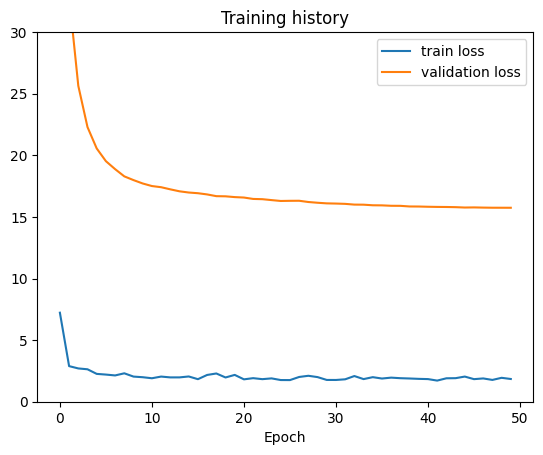

In [34]:
import matplotlib.pyplot as plt
#Plot training and validation accuracy
plt.plot(history["train_loss"], label='train loss')
plt.plot(history["valid_loss"], label='validation loss')
# Graph chars
plt.title('Training history')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 30]);

In [35]:
def prevision_mocap(model, input_mocap, device, max_output_length):
    model.eval()
    with torch.no_grad():
        input_mocap = torch.tensor(input_mocap).float().to(device)
        # input_mocap = [50, 57]
        input_mocap = input_mocap.unsqueeze(1)
        # input_mocap = [50, 1, 57]
        
        hidden, cell = model.encoder(input_mocap)
        # input_mocap = [1, 1, hidden_dim]
        # input_mocap = [1, 1, hidden_dim]

        input_mocap = input_mocap.squeeze(1)
        # input_mocap = [50, 57]
        previsions = [input_mocap[-1].tolist()]

        for _ in range(max_output_length):
            inputs_tensor = torch.tensor([previsions[-1]]).to(device)

            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            # output = [1, 57]
            output = output.tolist()
            previsions.append(output[0])
    
    del previsions[0]
    return np.array(previsions)


In [122]:
rand_x = random.randint(0, len(frame_vocab_copy))

input_mocap = np.array(frame_vocab_copy.values.tolist()[rand_x][:50])

deleted = input_mocap[:, indexes_to_exclude]

input_mocap_test = np.delete(input_mocap, indexes_to_exclude, axis=1)

expected_output_mocap = np.array(frame_vocab_copy.values.tolist()[rand_x][-25:])

prevision = prevision_mocap(
    model,
    input_mocap_test,
    device,
    max_output_length = expected_output_mocap.shape[0]
)

for i, column in enumerate(deleted[-25:].T):
    prevision = np.insert(prevision, indexes_to_exclude[i], column, axis=1)

input_mocap = input_mocap.reshape(50, 24, 3)
print(input_mocap.shape)

expected_output_mocap = expected_output_mocap.reshape(25, 24, 3)
print(expected_output_mocap.shape)

prevision = prevision.reshape(25, 24, 3)
print(prevision.shape)

(50, 24, 3)
(25, 24, 3)
(25, 24, 3)


In [123]:
print(len(frame_vocab.iloc[0]), len(frame_vocab[0][0]))
print(len(frame_vocab_copy.iloc[0]), len(frame_vocab_copy[0][0]))

75 57
75 72


In [124]:

input_mocap = kine.compute_fk(input_mocap, apply_root_rotation=True)
expected_output_mocap = kine.compute_fk(expected_output_mocap, apply_root_rotation=True)
prevision = kine.compute_fk(prevision, apply_root_rotation=True)

motions_list = [[input_mocap], [expected_output_mocap, prevision]]
subplot_ids = [[0], [0,1]]
subplot_titles = [['Input_mocap'], ['Expected_output_mocap', 'Prevision']]
camera_orientations = [[CameraOrientation(100, 20)], [CameraOrientation(100, 20), CameraOrientation(100, 20)]]

pose_animation(motions_list[0], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[0], 
               camera_orientations=camera_orientations[0], subplot_titles=subplot_titles[0],
               fig_opts={'dpi':90}, animation_mode=AnimationMode.HTML, gif_savepath='./test_outputs/input_mocap.gif')

pose_animation(motions_list[1], SmplConstants.PARENTS, animation_framerate = 25, subplot_ids=subplot_ids[1], 
               camera_orientations=camera_orientations[1], subplot_titles=subplot_titles[1],
               animation_mode=AnimationMode.HTML, gif_savepath='./test_outputs/expected_prevision.gif')